In [18]:
import numpy             as np
import matplotlib.pyplot as plt

from matplotlib          import rcParams, rc
# Change the matplotlib default parameters
# rcParams.update({'font.size':   12})
rcParams.update({'figure.dpi': 200})
# rc('font', family='serif')
# rc('text', usetex=True)

from astropy import units as units

from src.odes           import ODE
from src.rates          import initialise_abs, calculate_rates, read_specs_file
from src.input          import setinput, getcst, density

from scipy.integrate    import solve_ivp
from astropy            import constants

specs, parnt, consv = read_specs_file('C')

specs_dict = dict()
for i in range(len(specs)):
    specs_dict[specs[i]] = i

In [19]:


## input values physics
def setinput(Mdot, vexp, r, T, δ, Av, chemtype):
    '''
    Set input values of the model.

    INPUT:
        - ρ  = density       [g/cm^3]
            via mass-loss rate (Mdot [Msol/yr]) & expansion velocity (vexp [km/s])
        - T  = temperature   [K]
        - δ  = outwards dilution of radiation field     == RAD
        - Av = outward dus extinction
        - chemtype = type of chemistry: 'C' or 'O'
    '''

    ## input physics
    ρ = density(Mdot, vexp, r)

    print('Input:')
    print('------')
    print('ρ  =','{:.2E}'.format(ρ))
    print('T  =',T)
    print('δ  =',δ)
    print('Av =',Av)
    print('')
    print('Chem type =', chemtype)

    return ρ, T, δ, Av, chemtype

def solve(ρ, T, δ, Av, chemtype, Δt):

    ## calculate H accretion on dust
    Haccr = stckH *np.pi*(rGr**2.0)*ρ*nGr*(8.0*kB*T/(np.pi*mH))**0.5

    ## set initial conditions
    n, nconsv_tot, specs = initialise_abs(chemtype)     # nconsv_tot = TOTAL in fortran code
    timesteps = 1

    ndot        = np.zeros(len(n))
    nconsv      = np.zeros(len(nconsv_tot))
    t           = np.zeros(timesteps)

    k = calculate_rates(T, δ, Av)

    Δt = Δt*yr_to_sec  ## in sec


    print(' >> Solving ODE ...')
    ## solve ODE
    solution = solve_ivp(
        fun          = ODE,
        t_span       = [0.0, Δt],
        y0           = n,
        method       = 'BDF',   ## zoals DVODE
        args         = (ndot, nconsv, nconsv_tot,k, ρ, Haccr),
        dense_output = False    ## if True: returns interpolation function
        )

    assert solution['status'] == 0

    ys = solution['y']
    ts = solution['t']

    print(solution['message'])

    return ts, ys

def plot(ts, ys):
    fig = plt.figure(figsize=(8,6))

    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    axs = [ax1,ax2]

    for i in range(ys.shape[0]):
        ax1.plot(ts, ys[i])
        ax2.plot(ts, -ys[i])

    for ax in axs:
        ax.set_yscale('log')
        ax.set_xscale('log')

        # ax.set_ylim((1.0e-40, 1.0e+0))

    ax.set_xlabel('time [s]')
    ax1.set_ylabel('abundance')
    ax2.set_ylabel('negative abundance')

    plt.show()

    return

def search_negs(ys, elwise = False, el = None):
    idx_neg = list()

    if elwise == False:
        for i in range(ys.shape[0]):
            if np.any(ys[i] < 0):
                idx_neg.append(i)

    if elwise == True:
        for i in range(ys.shape[0]):
            if np.any(ys[i][el] < 0):
                idx_neg.append(i)


    specs_neg = list()

    for idx in idx_neg:
        specs_neg.append(specs[idx])

    return idx_neg, specs_neg

### Test simulations

In [20]:
## constants
kB, mH, rGr, nGr, stckH, AUV_AV = getcst()
yr_to_sec = units.year.to('s')         ## year in seconds

In [21]:
## Sim 1
ρ, T, δ, Av, chemtype = setinput(1.e-8, 5., 1.e15, 2500., 1., 1., 'C')
ts1, ys1 = solve(ρ, T, δ, Av, chemtype, 1.e1)

Input:
------
ρ  = 2.25E+04
T  = 2500.0
δ  = 1.0
Av = 1.0

Chem type = C
 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


In [24]:
## Sim 2
ρ, T, δ, Av, chemtype = setinput(1.e-6, 15., 1.e15, 2500., 1., 1., 'C')
ts2, ys2 = solve(ρ, T, δ, Av, chemtype, 1.e1)

Input:
------
ρ  = 7.51E+05
T  = 2500.0
δ  = 1.0
Av = 1.0

Chem type = C
 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


In [25]:
## Sim 3
ρ, T, δ, Av, chemtype = setinput(1.e-8, 5., 1.e15, 2500., 1., 1., 'O')
ts3, ys3 = solve(ρ, T, δ, Av, chemtype, 1.e1)

Input:
------
ρ  = 2.25E+04
T  = 2500.0
δ  = 1.0
Av = 1.0

Chem type = O
 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


In [26]:
## Sim 4
ρ, T, δ, Av, chemtype = setinput(1.e-8, 5., 1.e15, 2500., 1.e-5, 0.5, 'C')
ts4, ys4 = solve(ρ, T, δ, Av, chemtype, 1.e1)

Input:
------
ρ  = 2.25E+04
T  = 2500.0
δ  = 1e-05
Av = 0.5

Chem type = C
 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


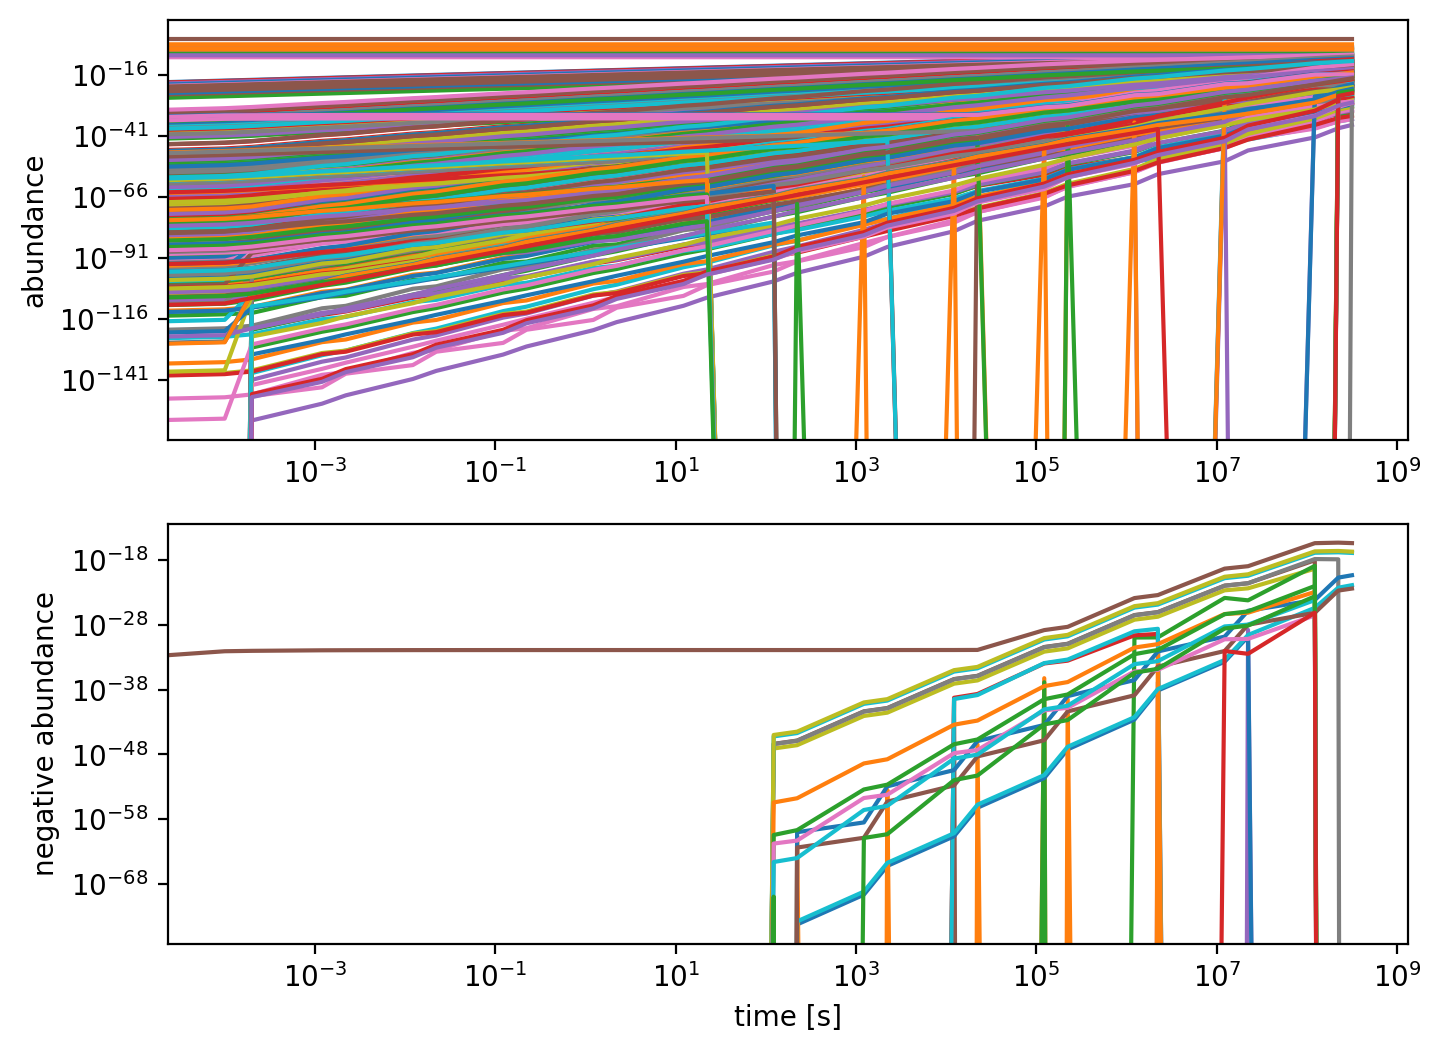

In [22]:
plot(ts1, ys1)
# plot(ts2,ys2)

### Search for negatives

In [23]:
## ys1 - sim 1

idx_neg, specs_neg = search_negs(ys1)
print(len(idx_neg))
print(idx_neg)
print(specs_neg)

23
[328, 375, 405, 407, 419, 421, 422, 423, 424, 438, 439, 440, 441, 449, 450, 451, 452, 455, 456, 459, 462, 463, 465]
['C5-', 'C6-', 'C7+', 'C7-', 'C8-', 'C8+', 'C8H', 'C8H+', 'C8H-', 'C9-', 'C9H+', 'C9H-', 'C9H', 'C10-', 'C10', 'C10+', 'C10H+', 'C9N', 'C9N+', 'HC9N+', 'H2C9N+', 'H3C9N+', 'C11+']


In [28]:
idx_neg, specs_neg = search_negs(ys1, elwise = True, el=1)
print(len(idx_neg))
for i in range(len(idx_neg)):
    print(idx_neg[i], specs_neg[i])

1
465 C11+


-8.214378875868903e-33


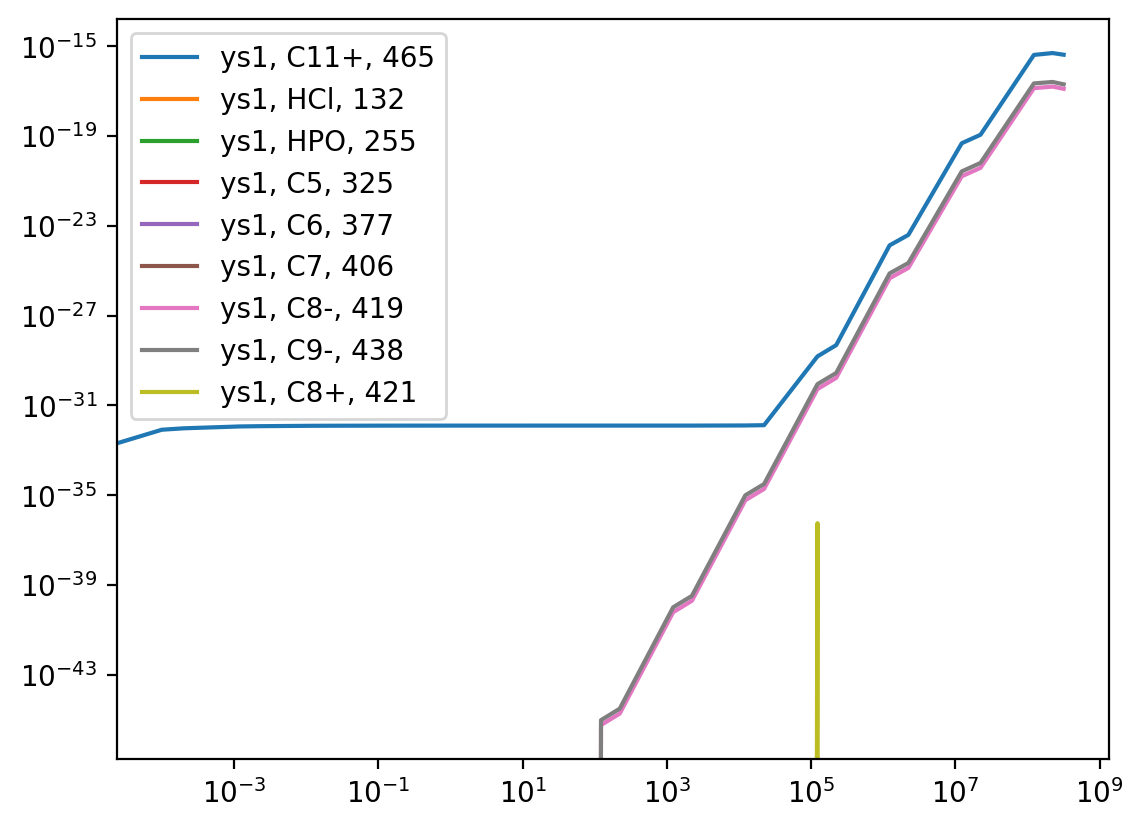

In [34]:
nbs = [465, 132, 255, 325, 377, 406, 419, 438, 421]
print(ys1[465][1])

for nb in nbs:
    plt.loglog(ts1, -ys1[nb], label = "ys1, "+specs[nb]+', '+str(nb))
    # plt.loglog(ts2, -ys2[nb], label = "ys2, "+specs[nb])
    # plt.loglog(ts3, -ys3[nb], label = "ys3, "+specs[nb])
    # plt.loglog(ts4, -ys4[nb], label = "ys4, "+specs[nb])
plt.legend(loc = 'upper left')
plt.show()

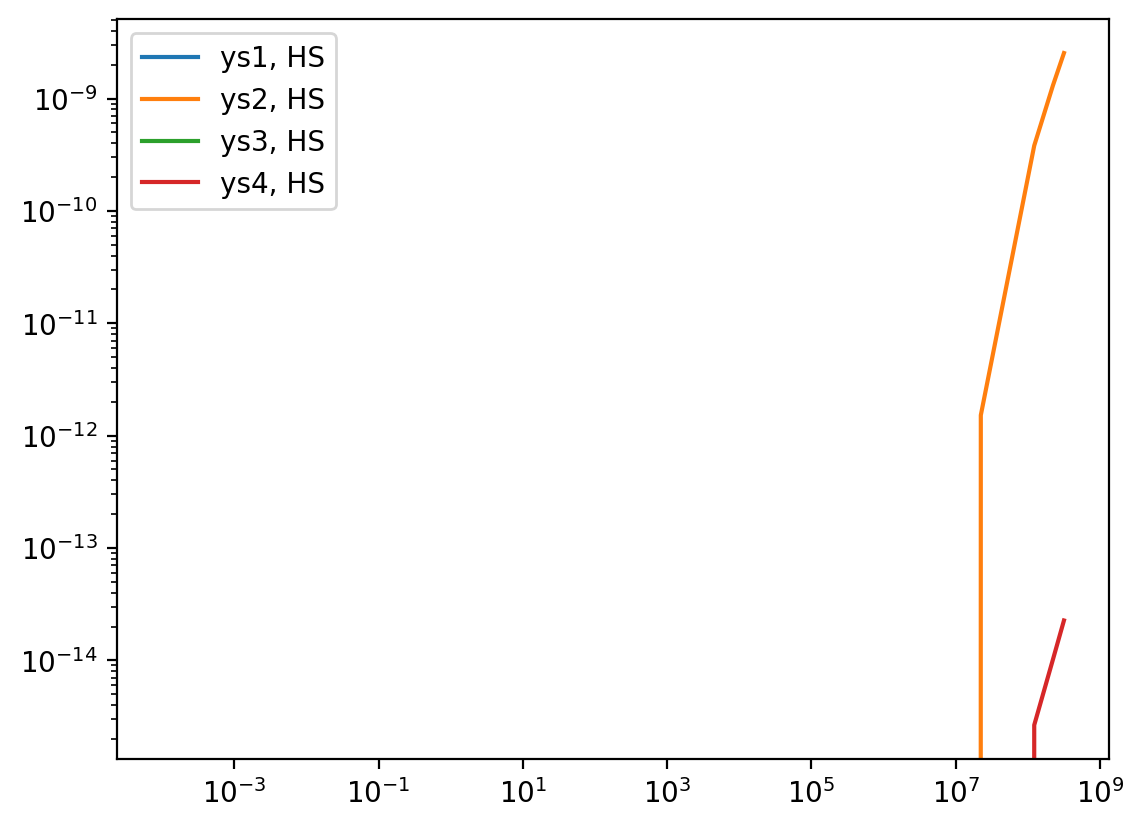

In [32]:
molecs = ['HS']

for molec in molecs:
    nb = specs_dict[molec]
    plt.loglog(ts1, -ys1[nb], label = "ys1, "+specs[nb])
    plt.loglog(ts2, -ys2[nb], label = "ys2, "+specs[nb])
    plt.loglog(ts3, -ys3[nb], label = "ys3, "+specs[nb])
    plt.loglog(ts4, -ys4[nb], label = "ys4, "+specs[nb])
plt.legend(loc = 'upper left')
plt.show()

In [54]:
ions = list()
for spec in specs:
    if spec[-1] == '+' or spec[-1] == '-':
        ions.append(spec)


In [55]:
len(ions)

296